<a href="https://colab.research.google.com/github/cowsilver57/sessac_test/blob/main/11%EC%9B%94_20%EC%9D%BC_(%EC%9B%94)_Day_53_%EC%8B%A4%EC%8A%B53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 3

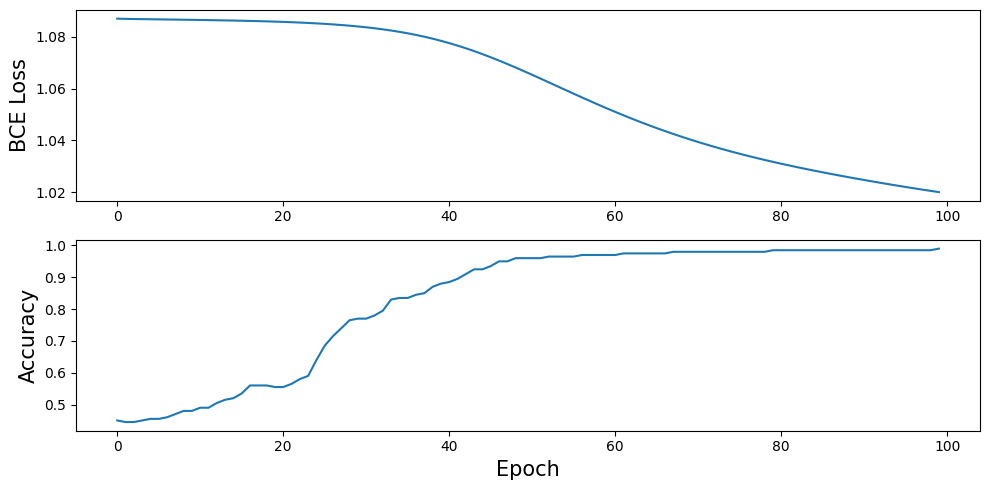

In [ ]:
#1.
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_blobs
from torch.utils.data import TensorDataset, DataLoader

N_SAMPLES = 100
BATCH_SIZE = 8
LR = 0.1

X1, y1 = make_blobs(n_samples=N_SAMPLES, centers=([-1,1],[-1,-1]), n_features=2, cluster_std=0.3)
X2, y2 = make_blobs(n_samples=N_SAMPLES, centers=([1,-1], [1,1]), n_features=2, cluster_std=0.3)

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

#2.
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(in_features=2, out_features=5)
        self.fc1_act = nn.Sigmoid()

        self.fc2 = nn.Linear(in_features=5, out_features=1)
        self.fc2_act = nn.Sigmoid()

    def forward(self,x):
        x = self.fc1(x)
        x = self.fc1_act(x)

        x = self.fc2(x)
        x = self.fc2_act(x)
        return x

#3.
from torch.optim import SGD
if torch.cuda.is_available(): DEVICE = 'cuda'
elif torch.backends.mps.is_available(): DEVICE = 'mps'
else: DEVICE = 'cpu'

model = MLP().to(DEVICE)
loss_function = nn.BCELoss()
optimizer = SGD(model.parameters(), lr=LR)

#4.
EPOCHS = 100
losses, accs = [],[]
for epoch in range(EPOCHS):
    epoch_loss, n_corrects = 0.,0
    for X, y in data_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        pred = model(X)
        y = y.reshape(pred.shape)
        loss = loss_function(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() + len(X)
        pred = (pred>0.5).type(torch.float)
        n_corrects += (pred==y).sum().item()

    epoch_loss /= (N_SAMPLES*2)
    losses.append(epoch_loss)
    epoch_acc = n_corrects / (N_SAMPLES*2)
    accs.append(epoch_acc)

    #print(f"Epoch: {epoch+1}")
    #print(f"Losss: {epoch+loss:.4f} - ACC: {epoch_acc:.4f}\n")

#5.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(losses)
axes[1].plot(accs)
axes[1].set_xlabel("Epoch", fontsize=15)
axes[0].set_ylabel("BCE Loss", fontsize=15)
axes[1].set_ylabel("Accuracy", fontsize=15)
axes[0].tick_params(labelsize=10)
axes[1].tick_params(labelsize=10)
fig.tight_layout()
plt.show()

<ipython-input-38-2f29d1c93c23>:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


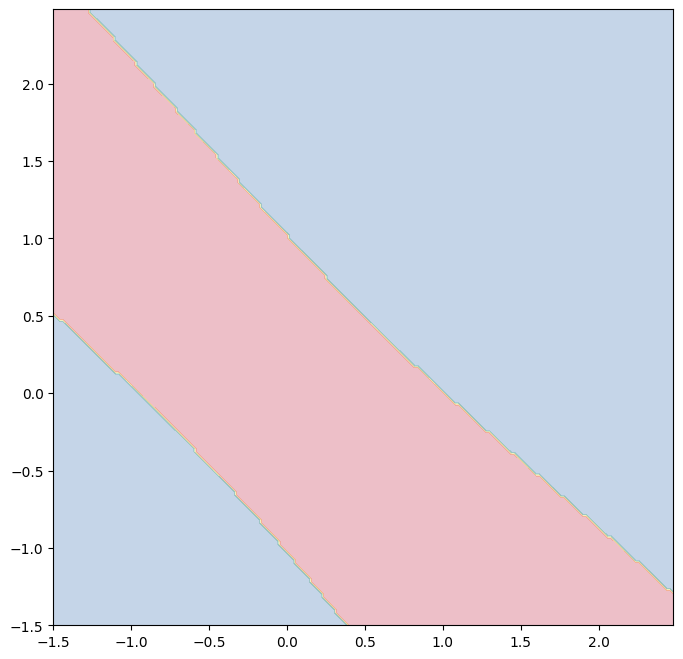

In [ ]:
def create_meshgrid(data, h=0.02):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# 시각화를 위한 meshgrid 생성
meshgrid_data = np.concatenate((X1, X2), axis=0)
xx, yy = create_meshgrid(meshgrid_data)

# meshgrid를 PyTorch 텐서로 변환하고 디바이스로 이동
meshgrid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(DEVICE)

# 모델을 사용하여 meshgrid에서 예측
with torch.no_grad():
    predictions = model(meshgrid_tensor)
    predictions = (predictions > 0.5).type(torch.float).cpu().numpy().reshape(xx.shape)

# 결정 경계와 데이터 포인트를 함께 플로팅
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, predictions, cmap=plt.cm.Spectral, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.show()